### Original SuperRes Pipeline

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [50]:
# -------- Dataset Loader (CIFAR10 as example) --------
transform_raw = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = datasets.CelebA(root='./data', download=True, transform=transform_raw)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
#test_data = datasets.CelebA(root='./data', train=False, download=True, transform=transform_raw)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [30]:
# -------- Traditional Functions --------
def apply_white_balance(img_tensor, gains=(1.2, 1.0, 0.9)):
    img = img_tensor.clone()
    img[0] *= gains[0]
    img[1] *= gains[1]
    img[2] *= gains[2]
    return torch.clamp(img, 0, 1)

def apply_gaussian_blur(img_tensor, ksize=5, sigma=1.5):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_blurred = cv2.GaussianBlur(img_np, (ksize, ksize), sigma)
    img_tensor_blurred = torch.from_numpy(img_blurred.astype(np.float32) / 255.0).permute(2, 0, 1)
    return img_tensor_blurred

def apply_gamma_correction(img_tensor, gamma=2.2):
    return torch.clamp(img_tensor, 1e-8, 1.0) ** (1 / gamma)

# -------- Super-Resolution Neural Network --------
class UpsampleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(3, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def forward(self, x):
        return self.upsample(x)

In [31]:
model = UpsampleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -------- Training --------
for epoch in range(75):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, mode='bicubic', align_corners=False).squeeze(0)
            img_lr = apply_white_balance(img_lr)
            img_lr = apply_gaussian_blur(img_lr)
            img_lr = apply_gamma_correction(img_lr)
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)

        # Forward
        outputs = model(batch_lr)
        loss = criterion(outputs, images)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/75, Total_loss:{total_loss}")

# -------- Save Model --------
torch.save(model.state_dict(), "traditional_to_trainable_sr.pth")
print("Model saved to traditional_to_trainable_sr.pth")

Epoch 1/75, Total_loss:69.27700275089592
Epoch 2/75, Total_loss:58.59605152811855
Epoch 3/75, Total_loss:55.487216477049515
Epoch 4/75, Total_loss:53.58807098539546
Epoch 5/75, Total_loss:52.45274300780147
Epoch 6/75, Total_loss:51.53869450907223
Epoch 7/75, Total_loss:50.99469060241245
Epoch 8/75, Total_loss:50.45226596458815
Epoch 9/75, Total_loss:50.09074607049115
Epoch 10/75, Total_loss:49.706583318300545
Epoch 11/75, Total_loss:49.38854112336412
Epoch 12/75, Total_loss:49.08919171919115
Epoch 13/75, Total_loss:48.84256965434179
Epoch 14/75, Total_loss:48.58035979606211
Epoch 15/75, Total_loss:48.34446317492984
Epoch 16/75, Total_loss:48.160998676205054
Epoch 17/75, Total_loss:48.03224092395976
Epoch 18/75, Total_loss:47.845312307588756
Epoch 19/75, Total_loss:47.69981720345095
Epoch 20/75, Total_loss:47.61132565769367
Epoch 21/75, Total_loss:47.458412668900564
Epoch 22/75, Total_loss:47.33161880658008
Epoch 23/75, Total_loss:47.25047237821855
Epoch 24/75, Total_loss:47.17467605439

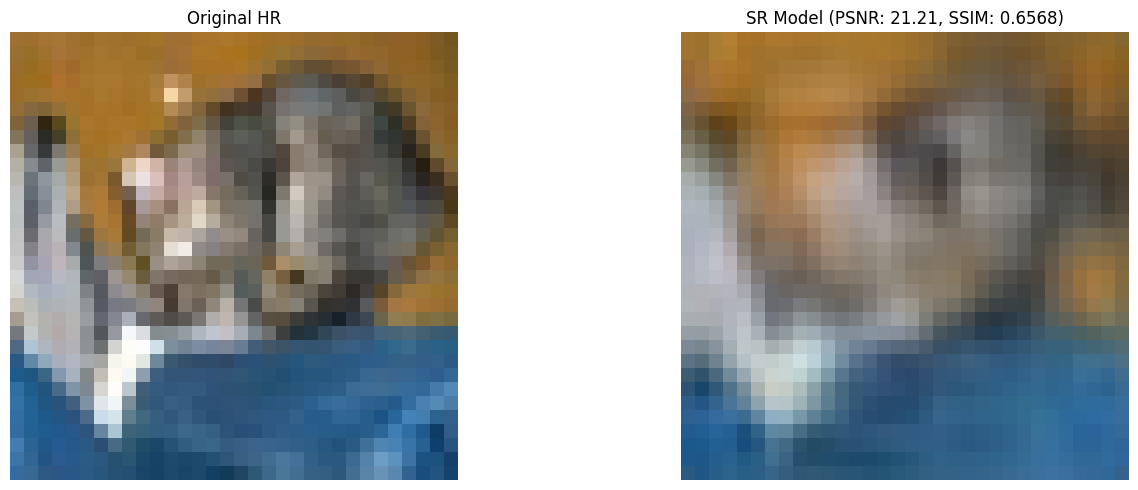

SR Model - Avg PSNR: 22.02 dB, Avg SSIM: 0.7049


In [44]:
# -------- Metrics for comparison --------
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original, generated):
    """Calculate PSNR and SSIM between original and generated images"""
    original_np = original.permute(1, 2, 0).cpu().numpy()
    generated_np = generated.permute(1, 2, 0).cpu().numpy()
    
    # Clip values to valid range for metrics
    original_np = np.clip(original_np, 0, 1)
    generated_np = np.clip(generated_np, 0, 1)
    
    # Calculate PSNR
    psnr_value = psnr(original_np, generated_np, data_range=1.0)
    
    # Calculate SSIM (channel by channel for color images)
    ssim_value = ssim(original_np, generated_np, data_range=1.0, channel_axis=2, multichannel=True)
    
    return psnr_value, ssim_value

# Add this at the end of your evaluation section
model.eval()
total_psnr_bicubic = 0
total_ssim_bicubic = 0
total_psnr_sr = 0
total_ssim_sr = 0
num_images = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            # Downsample
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, 
                                                   mode='bicubic', align_corners=False).squeeze(0)
            # Apply traditional processing
            img_lr = apply_white_balance(img_lr)
            img_lr = apply_gaussian_blur(img_lr)
            img_lr = apply_gamma_correction(img_lr)
                        
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)        
        outputs = model(batch_lr)

        # Calculate metrics
        for i in range(len(images)):
            # Calculate metrics for our SR model
            psnr_sr, ssim_sr = calculate_metrics(images[i], outputs[i])
            total_psnr_sr += psnr_sr
            total_ssim_sr += ssim_sr
            
            num_images += 1
            
            # Visualize a few examples
            if num_images == 1:
                fig, axs = plt.subplots(1, 2, figsize=(15, 5))
                axs[0].imshow(images[i].permute(1, 2, 0).cpu())
                axs[0].set_title(f"Original HR")
                axs[0].axis('off')
               
                axs[1].imshow(outputs[i].permute(1, 2, 0).clamp(0, 1).cpu())
                axs[1].set_title(f"SR Model (PSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.4f})")
                axs[1].axis('off')
                
                plt.tight_layout()
                plt.show()
        
        # Process a certain number of batches for evaluation
        if num_images >= 100:
            break

# Print average metrics
avg_psnr_sr = total_psnr_sr / num_images
avg_ssim_sr = total_ssim_sr / num_images

print(f"SR Model - Avg PSNR: {avg_psnr_sr:.2f} dB, Avg SSIM: {avg_ssim_sr:.4f}")

### Differentiable

In [45]:
import torch.nn.functional as F
# -------- Differentiable White Balance --------
class WhiteBalance(nn.Module):
    def __init__(self):
        super().__init__()
        self.gains = nn.Parameter(torch.ones(3))  # R, G, B gain

    def forward(self, x):
        return x * self.gains.view(1, -1, 1, 1)

# -------- Differentiable Gaussian Blur --------
class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=5, sigma=1.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

    def forward(self, x):
        channels = x.shape[1]
        kernel_1d = torch.arange(self.kernel_size, dtype=torch.float32) - self.kernel_size // 2
        kernel_1d = torch.exp(-kernel_1d ** 2 / (2 * self.sigma ** 2))
        kernel_1d = kernel_1d / kernel_1d.sum()
        kernel_2d = torch.outer(kernel_1d, kernel_1d)
        kernel = kernel_2d.expand(channels, 1, -1, -1).to(x.device)
        return F.conv2d(x, kernel, padding=self.kernel_size//2, groups=channels)

# -------- Differentiable Tone Mapping (Gamma) --------
class GammaCorrection(nn.Module):
    def __init__(self, gamma=2.2):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(gamma))

    def forward(self, x):
        return torch.clamp(x, 1e-8, 1) ** (1 / self.gamma)

# -------- Super-Resolution Pipeline --------
class CameraSuperResPipeline(nn.Module):
    def __init__(self):
        super().__init__()
        self.white_balance = WhiteBalance()
        self.blur = GaussianBlur(kernel_size=5, sigma=1.5)
        self.tone = GammaCorrection(gamma=2.2)
        self.upsample = UpsampleCNN()

    def forward(self, x_hr):
        x_lr = self.white_balance(x_hr)
        x_lr = self.blur(x_lr)
        x_lr = self.tone(x_lr)
        x_sr = self.upsample(x_lr) 
        return x_sr


In [46]:
model = CameraSuperResPipeline().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -------- Training --------
for epoch in range(75):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, mode='bicubic', align_corners=False).squeeze(0)
            img_lr = apply_white_balance(img_lr)
            img_lr = apply_gaussian_blur(img_lr)
            img_lr = apply_gamma_correction(img_lr)
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)

        # Forward
        outputs = model(batch_lr)
        loss = criterion(outputs, images)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# -------- Save Model --------
torch.save(model.state_dict(), "traditional_to_trainable_sr.pth")
print("Model saved to traditional_to_trainable_sr.pth")

Epoch 1: Loss = 98.9876
Epoch 2: Loss = 73.5738
Epoch 3: Loss = 68.3302
Epoch 4: Loss = 64.3841
Epoch 5: Loss = 62.0064
Epoch 6: Loss = 60.4475
Epoch 7: Loss = 59.2785
Epoch 8: Loss = 58.4292
Epoch 9: Loss = 57.7673
Epoch 10: Loss = 57.1451
Epoch 11: Loss = 56.6086
Epoch 12: Loss = 56.1462
Epoch 13: Loss = 55.7035
Epoch 14: Loss = 55.3161
Epoch 15: Loss = 54.8929
Epoch 16: Loss = 54.5061
Epoch 17: Loss = 54.1469
Epoch 18: Loss = 53.8601
Epoch 19: Loss = 53.5517
Epoch 20: Loss = 53.3024
Epoch 21: Loss = 53.0463
Epoch 22: Loss = 52.8088
Epoch 23: Loss = 52.6390
Epoch 24: Loss = 52.4574
Epoch 25: Loss = 52.2840
Epoch 26: Loss = 52.1502
Epoch 27: Loss = 51.9747
Epoch 28: Loss = 51.8569
Epoch 29: Loss = 51.7016
Epoch 30: Loss = 51.5971
Epoch 31: Loss = 51.5083
Epoch 32: Loss = 51.3868
Epoch 33: Loss = 51.2581
Epoch 34: Loss = 51.2268
Epoch 35: Loss = 51.1533
Epoch 36: Loss = 50.9869
Epoch 37: Loss = 50.9254
Epoch 38: Loss = 50.8431
Epoch 39: Loss = 50.7634
Epoch 40: Loss = 50.6830
Epoch 41:

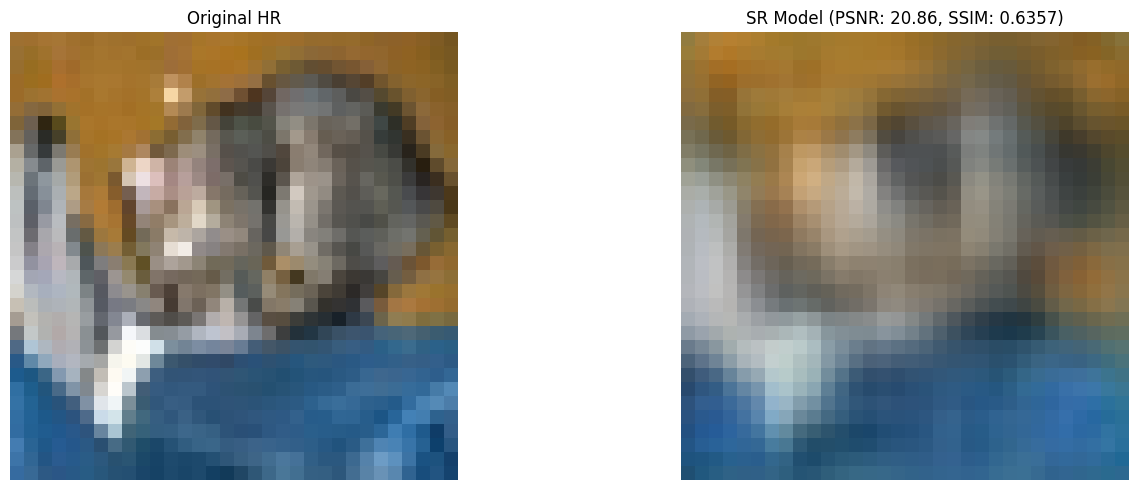

SR Model - Avg PSNR: 21.76 dB, Avg SSIM: 0.6871


In [48]:

# Add this at the end of your evaluation section
model.eval()
total_psnr_bicubic = 0
total_ssim_bicubic = 0
total_psnr_sr = 0
total_ssim_sr = 0
num_images = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            # Downsample
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, 
                                                   mode='bicubic', align_corners=False).squeeze(0)
            # Apply traditional processing
            img_lr = apply_white_balance(img_lr)
            img_lr = apply_gaussian_blur(img_lr)
            img_lr = apply_gamma_correction(img_lr)
                        
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)        
        outputs = model(batch_lr)

        # Calculate metrics
        for i in range(len(images)):
            # Calculate metrics for our SR model
            psnr_sr, ssim_sr = calculate_metrics(images[i], outputs[i])
            total_psnr_sr += psnr_sr
            total_ssim_sr += ssim_sr
            
            num_images += 1
            
            # Visualize a few examples
            if num_images == 1:
                fig, axs = plt.subplots(1, 2, figsize=(15, 5))
                axs[0].imshow(images[i].permute(1, 2, 0).cpu())
                axs[0].set_title(f"Original HR")
                axs[0].axis('off')
               
                axs[1].imshow(outputs[i].permute(1, 2, 0).clamp(0, 1).cpu())
                axs[1].set_title(f"SR Model (PSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.4f})")
                axs[1].axis('off')
                
                plt.tight_layout()
                plt.show()
        
        # Process a certain number of batches for evaluation
        if num_images >= 100:
            break

# Print average metrics
avg_psnr_sr = total_psnr_sr / num_images
avg_ssim_sr = total_ssim_sr / num_images

print(f"SR Model - Avg PSNR: {avg_psnr_sr:.2f} dB, Avg SSIM: {avg_ssim_sr:.4f}")